In [21]:
# Import GmGM functions
from GmGM.dataset import Dataset
from GmGM.core.preprocessing import center, grammify
from GmGM.core.core import calculate_eigenvectors, calculate_eigenvalues
from GmGM.core.presparse_methods import recompose_sparse_precisions

# Dask is a dependency of GmGM
import dask.array as da

In [3]:
# Import scanpy/anndata to show use in omics context
# These are not dependencies of the GmGM package
import scanpy as sc
import anndata as ad

In [16]:
# scanpy often raises NumbaDeprecation warnings and other warnings not relevant to the user
import warnings
warnings.filterwarnings(action='ignore', module='scanpy')

# "Small" dataset

> Paul et al. (2015), Transcriptional Heterogeneity and Lineage Commitment in Myeloid Progenitors

This dataset is small (<3000 cells, <3500 genes) so it makes a good first example.

In [18]:
paul15 = sc.datasets.paul15()
paul15.obs['paul15_clusters'] = paul15.obs['paul15_clusters'].astype('category')
sc.pp.log1p(paul15)
paul15

AnnData object with n_obs × n_vars = 2730 × 3451
    obs: 'paul15_clusters'
    uns: 'iroot', 'log1p'

In [19]:

sc.pp.pca(paul15, n_comps=20)
sc.pp.neighbors(paul15)
sc.tl.umap(paul15)

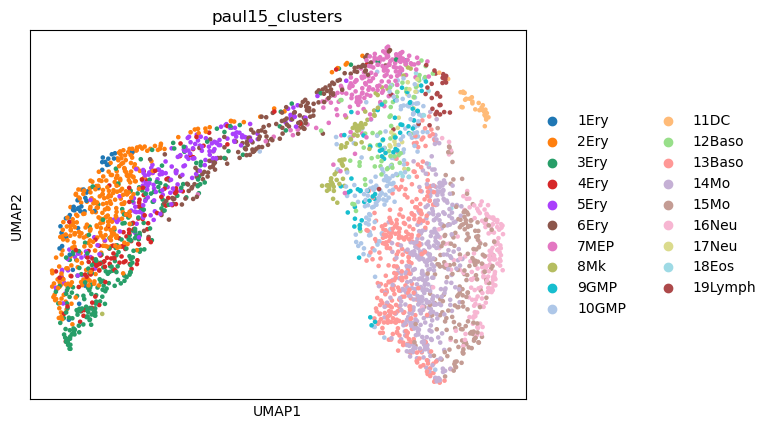

In [20]:
sc.pl.umap(paul15, color='paul15_clusters')

In [24]:
dataset: Dataset = Dataset(
    dataset={
        "scRNA": da.from_array(paul15.X)
    },
    structure={
        "scRNA": ("cell", "gene")
    }
)
dataset.print_memory_usage()
dataset

TypeError: unsupported operand type(s) for |: 'type' and 'type'